Notebook for the construction and application of a MACH filter given a bank of microglia images and test data

Requires 
- imutil
- opencv
- pygame


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os

import mach
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mach_util
import math

sys.path = ["./matchedmyo/"] + sys.path
import util
import matchedmyo as mm

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# First Big Step: Crop Out Microglia From Scanned Image for Making MACH Filter



In [2]:
filter_root = "./cropped_cells/"
# currently we have two kinds of filters, the 'good' ones (ramified)  and the 'bad ones' (rod-shaped)
# in the future, we may need more filters such as the 'hypertrophic' ones


#Load the cropped cells 

ram_cells = [a for a in os.listdir(filter_root) if a[:3] == 'ram']
rod_cells = [a for a in os.listdir(filter_root) if a[0:3] == 'rod']

ram_cell_images = [util.ReadImg(filter_root + name).astype(np.uint8) for name in ram_cells if name[-4:] == '.tif']
rod_cell_images = [util.ReadImg(filter_root + name).astype(np.uint8) for name in rod_cells if name[-4:] == '.tif']


In [3]:
def displayMultImage(images,cmap=None,numbering=True):
    """
    Function to display the cropped representative microglia cells
    """
    N = len(images)
    if cmap == None:
        # check the if the image is RGB or grayscale
        if len(np.shape(images[0])) == 2:
                cmap='gray'
        else:
                cmap=None

            
        #now of rows, each row has maxi 25 columns
    nRows = math.ceil(N / 25.0)
    nColumns = 25
        
    figure = plt.figure(figsize=(nColumns,nRows))
            
    for i,img in enumerate(images):
            plt.subplot(nRows,nColumns,i+1)
            plt.imshow(img,cmap=cmap)
            plt.xticks([])
            plt.yticks([])
            if numbering:
                plt.title(str(i+1))
            plt.subplots_adjust(wspace=0,hspace=0)

In [4]:
def invert_gray_scale(images):
    """
    make cells as white and background as black
    """
    new_images=[]
    for i in images:
        new_images.append(255 - i)
    return new_images

In [5]:
def normalize(image):
    """
    Normolize the gray_scale image
    """
    newimage = image/np.max(image)
    return newimage

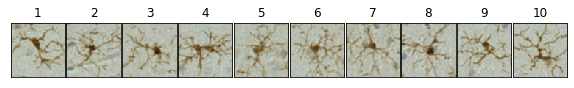

In [6]:
# display the filter images to get an idea of what they look like
displayMultImage(ram_cell_images)

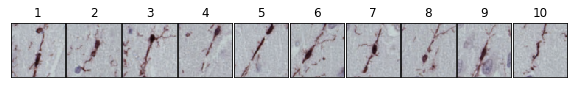

In [7]:
displayMultImage(rod_cell_images)

In [8]:
# convert to grayscale
ram_cells_gray_scale = [normalize(invert_gray_scale(cv2.cvtColor(name,cv2.COLOR_RGB2GRAY))) for name in ram_cell_images ]
rod_cells_gray_scale = [normalize(invert_gray_scale(cv2.cvtColor(name,cv2.COLOR_RGB2GRAY))) for name in rod_cell_images ]


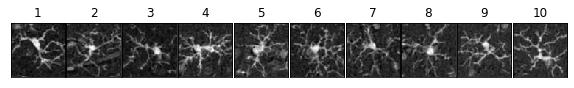

In [9]:
displayMultImage(ram_cells_gray_scale)


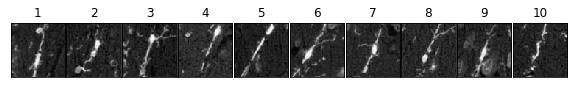

In [10]:
displayMultImage(rod_cells_gray_scale)


In [12]:
import imutils

In [13]:
# rotate the ramified cells to 90, 180 and 270 degree
ram_cell_90 = [imutils.rotate(i,90) for i in ram_cells_gray_scale]
ram_cell_180 = [imutils.rotate(i,180) for i in ram_cells_gray_scale]
ram_cell_270 = [imutils.rotate(i,270) for i in ram_cells_gray_scale]

# rotate the rod_shaped cells 180 degree
rod_cell_180 = [imutils.rotate(i,180) for i in rod_cells_gray_scale]

In [14]:
# collect all ramified cells and rod shaped cells, including the rotated ones
ram_filter_list = np.moveaxis(np.dstack(ram_cells_gray_scale+\
                                        ram_cell_90+\
                                        ram_cell_180+\
                                        ram_cell_270),source=2,destination=0).astype(float)
rod_filter_list = np.moveaxis(np.dstack(rod_cells_gray_scale+\
                                       rod_cell_180),source=2,destination=0).astype(float)


# Second Big Step: Make the MACH Filter, using the filter lists above

In [15]:
ram_filter = mach.MACH2(
    ram_filter_list,
    alpha = 1000,
    beta =  1e-10,
    gamma = 1e-15,
    displayFilter=False
)
ram_filter /= np.sum(ram_filter)



rod_filter = mach.MACH2(
    rod_filter_list,
    alpha = 1000,
    beta =  1e-10,
    gamma = 1e-15,
    displayFilter=False
)
rod_filter /= np.sum(rod_filter)



Text(0.5, 1.0, 'Rod MACH filter')

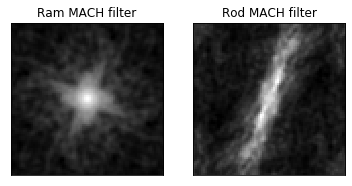

In [16]:
# Now display the filters to see what they look like
plt.subplot(1,2,1)
plt.imshow(ram_filter,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Ram MACH filter')
plt.subplot(1,2,2)
plt.imshow(rod_filter,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Rod MACH filter')


# Third Big Step: Try Out the Filter

In [19]:
# Now apply the above two filters on the test images


path=os.path.join(os.getcwd(),"TestImages/")

test_image_names = ['healthy.tif','unhealthy.tif'] 

#read in the 1000x1000 size images
test_image = [util.ReadImg(path+i).astype(np.uint8)[0:1000,0:1000,:] for i in test_image_names]

# convert to grayscale and invert the intensity
test_image_gray_scale = [np.asarray(invert_gray_scale(cv2.cvtColor(i,cv2.COLOR_RGB2GRAY))) for i in test_image]

#Normolization
test_image_gray_scale = [np.divide(i.astype(float),np.amax(i)) for i in test_image_gray_scale]

([], <a list of 0 Text yticklabel objects>)

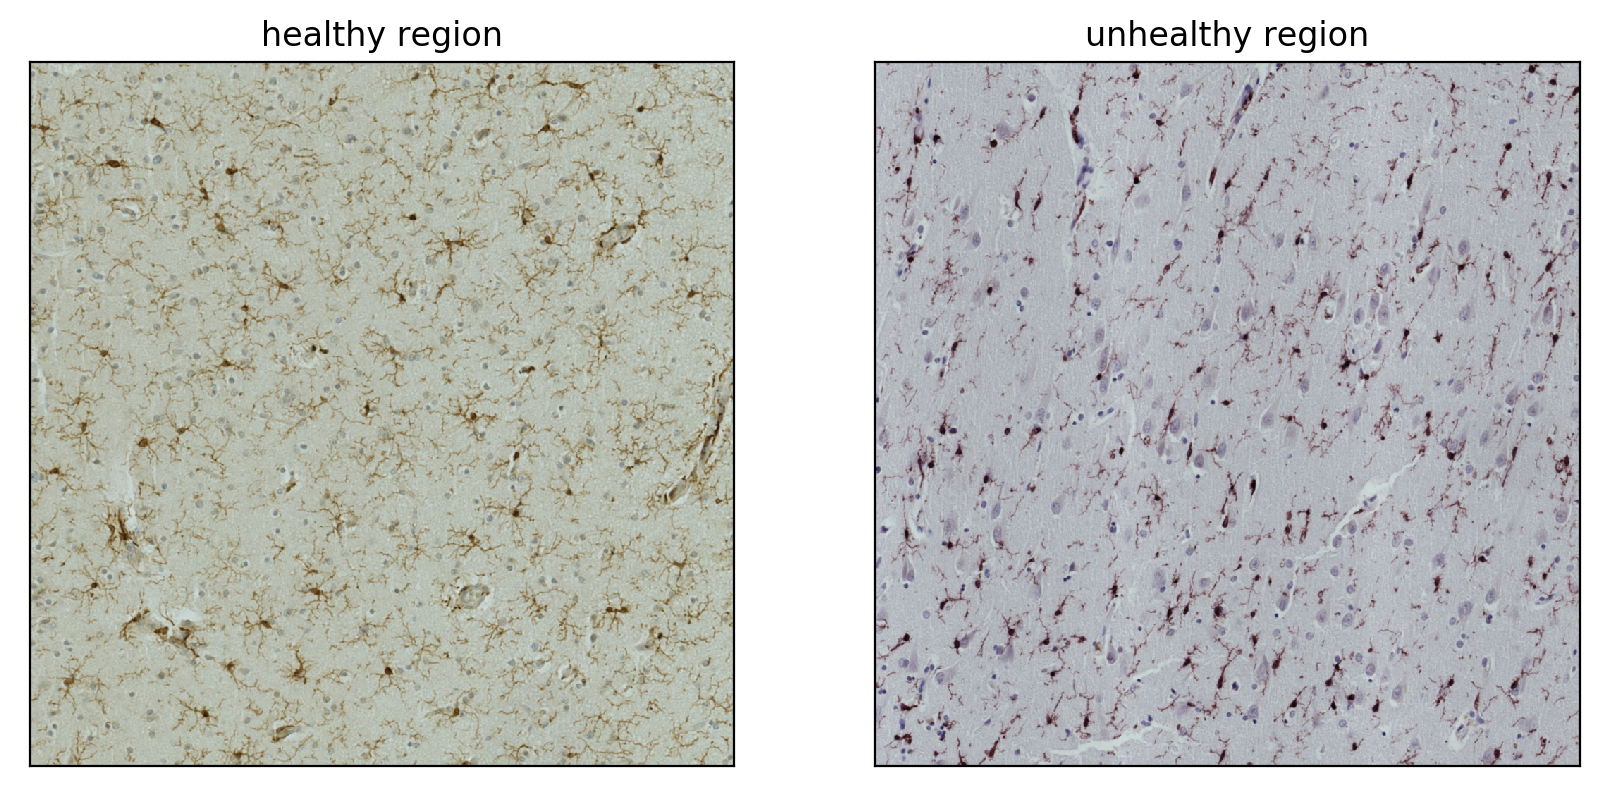

In [21]:
plt.figure(figsize=(10,10),dpi=200)
plt.subplot(1,2,1)
plt.imshow(test_image[0],cmap='gray')
plt.title('healthy region')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(test_image[1],cmap='gray')
plt.title('unhealthy region')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

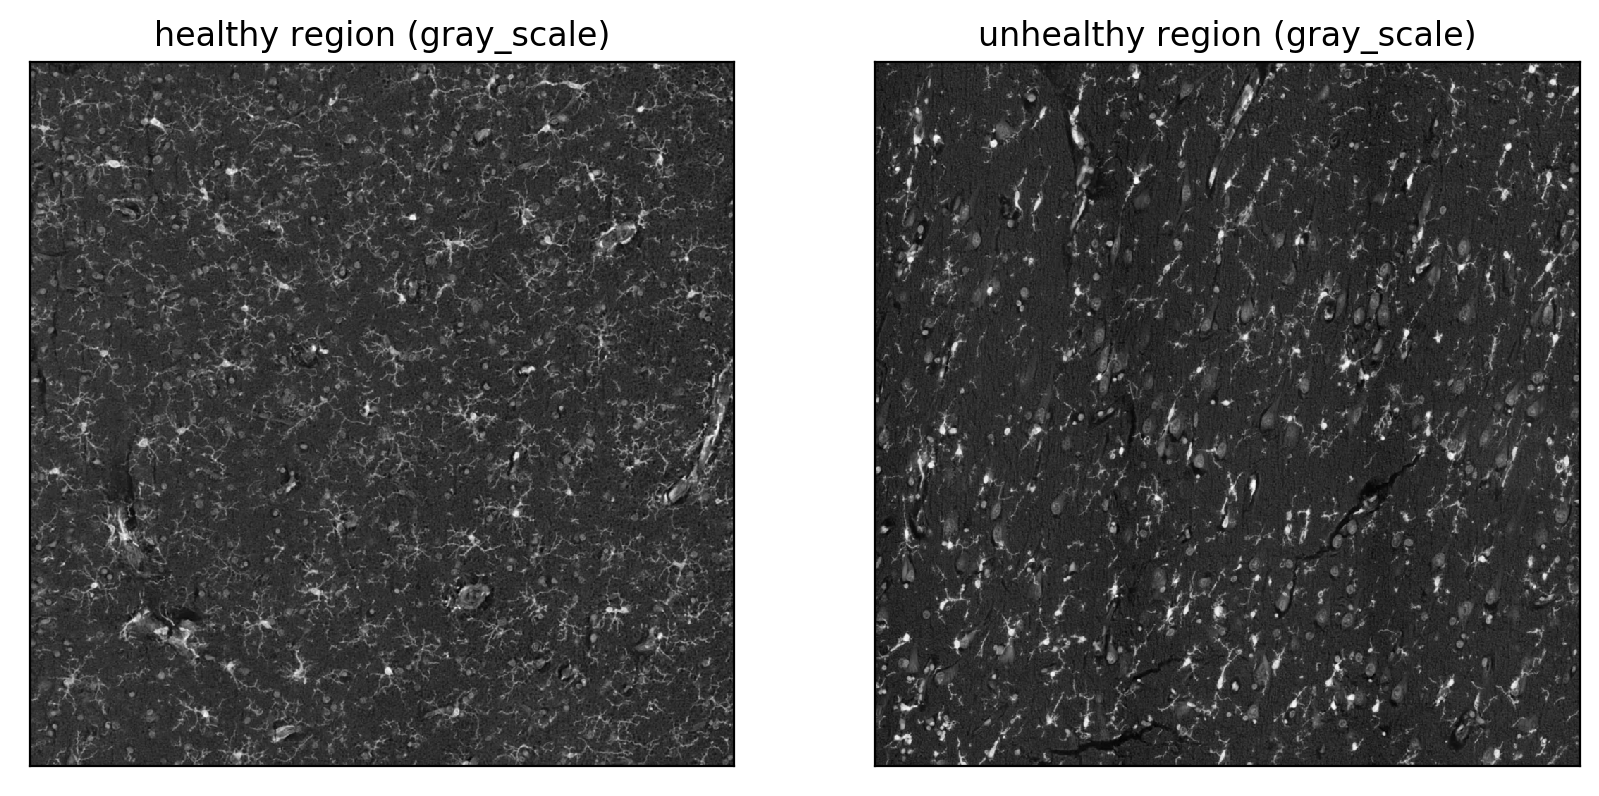

In [22]:
plt.figure(figsize=(10,10),dpi=200)
plt.subplot(1,2,1)
plt.imshow(test_image_gray_scale[0],cmap='gray')
plt.title('healthy region (gray_scale)')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(test_image_gray_scale[1],cmap='gray')
plt.title('unhealthy region (gray_scale)')
plt.xticks([])
plt.yticks([])

In [23]:
# do convolution; two filters, two images 
healthy_response = [ndimage.convolve(test_image_gray_scale[0], i) for i in [ram_filter,rod_filter]]
unhealthy_response = [ndimage.convolve(test_image_gray_scale[1], i) for i in [ram_filter,rod_filter]]


In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [27]:
def plot_response_image(response,datatype,cmap=None,sameVmax=True):
    """
    used to display all kinds of response
    datatype =  'filter_response --> the direct hits after convolution
                'SNR' --> annulus SNR on filter_response
                'thresSNR' --> binary image after thresholding SNR
                'colored_response' --> annoted image with detected ramified_cells as green 
                                       and rod_shaped cells as red
    """
    colorbar = True
    
    ram_resp = response[0]
    rod_resp = response[1]
 
    # use the same vmax 
    if sameVmax:
        vmax = np.amax([np.max(ram_resp),np.max(rod_resp)])
        vmax = [vmax,vmax]
    else:
        vmax = [np.max(ram_resp),np.max(rod_resp)]
    if cmap == None:
        cmap = 'rainbow'
    else:
        cmap = cmap
    
    if datatype == 'filter_response':
        title = ['response to ram filter','response to rod filter']
    elif datatype == 'SNR':
        title = ['ram filter annulus SNR', 'rod filter annulus SNR']
    elif datatype == 'thresSNR':
        title = ['SNR at %s' % (str(RAM_FILTER_SNR_THRES)),'SNR at %s' % (str(ROD_FILTER_SNR_THRES))]
        cmap = 'gray'
        vmax = [1.0,1.0]
        colorbar = False
    elif datatype == 'colored_response':
        title = ['SNR at %s' % (str(RAM_FILTER_SNR_THRES)),'SNR at %s' % (str(ROD_FILTER_SNR_THRES))]
        cmap = None
        colorbar = False
    
    figure = plt.figure(figsize=(10,10))
    ax1 = plt.subplot(1,2,1)
    ax1.imshow(ram_resp,cmap=cmap,vmax=vmax[0])
    ax1.set_title(title[0])
    ax2 = plt.subplot(1,2,2)
    im = ax2.imshow(rod_resp,cmap=cmap,vmax=vmax[1])
    ax2.set_title(title[1])
  

    
    if colorbar:
        axins = inset_axes(ax2,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
        figure.colorbar(im,cax=axins)

filter response to the healthy test image


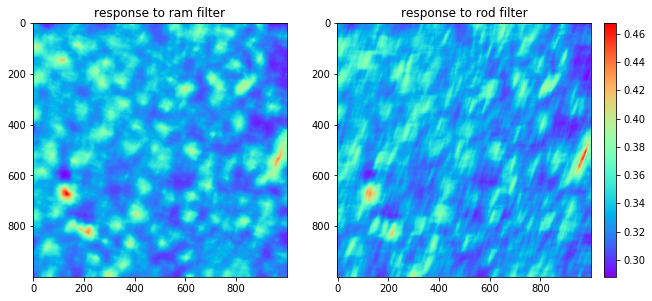

In [30]:
print ("filter response to the healthy test image")
plot_response_image(healthy_response,datatype='filter_response')

filter response to the unhealthy test image


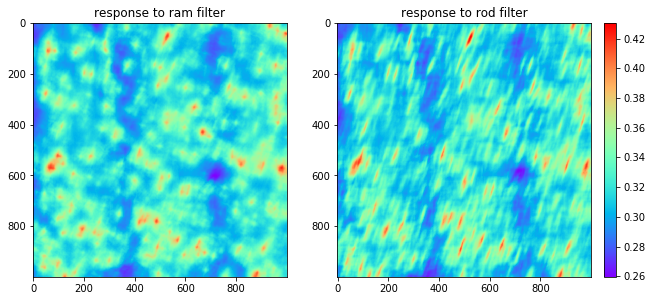

In [31]:
print ("filter response to the unhealthy test image")
plot_response_image(unhealthy_response,datatype='filter_response')

### Look at the above filter responses, for the same test image, the two filters have similar responses. We need to post-process the response using the annulus filters to get uique response of each filter 

In [32]:
import mach_util as mu

In [33]:
# get the SNR (signal noise ratio) after applying the annulus filter, essentially
#calculate the ratio of peak to neighbouring area

#first define the parameters 
RAM_FILTER_SNR_THRES = 1.031
ROD_FILTER_SNR_THRES = 1.032

INNER_RADIUS = 20
OUTER_RADIUS = 25


In [34]:
def get_annulus_SNR(response):
    results = []
    ram_resp = response[0]
    rod_resp = response[1]
   
    results.append(mu.giveAnnulusSNR(ram_resp,INNER_RADIUS,OUTER_RADIUS,thresh=RAM_FILTER_SNR_THRES,verbose=False))
    results.append(mu.giveAnnulusSNR(rod_resp,INNER_RADIUS,OUTER_RADIUS,thresh=ROD_FILTER_SNR_THRES,verbose=False))
   
    return results
    

In [35]:
healthy_response_SNR = get_annulus_SNR(healthy_response)
unhealthy_response_SNR = get_annulus_SNR(unhealthy_response)

after applying the annulus filtering, we got


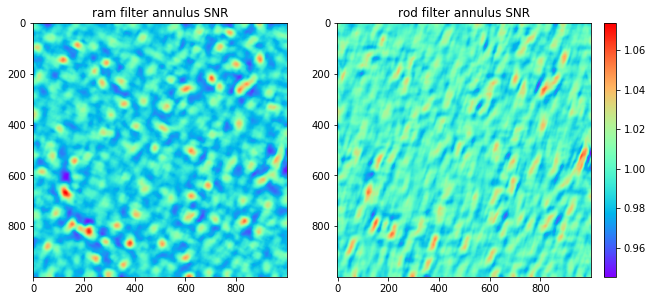

In [38]:
print ('after applying the annulus filtering, we got')
plot_response_image([healthy_response_SNR[0][0],healthy_response_SNR[1][0]],'SNR',sameVmax=True)

thresholding the SNR response, we got the detected ramifide cells and rod shaped cells in the healthy region


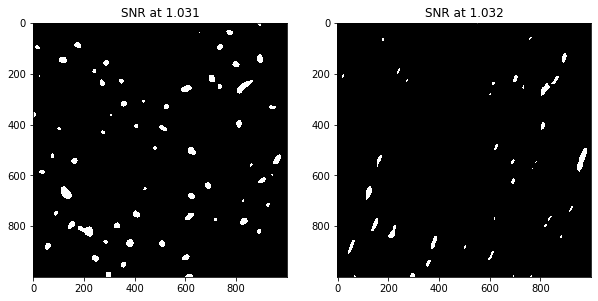

In [41]:
print ("thresholding the SNR response, we got the detected ramifide cells and rod shaped cells in the healthy region")
plot_response_image([healthy_response_SNR[0][1],healthy_response_SNR[1][1]],datatype='thresSNR',sameVmax=False)

this is the unhealthy region


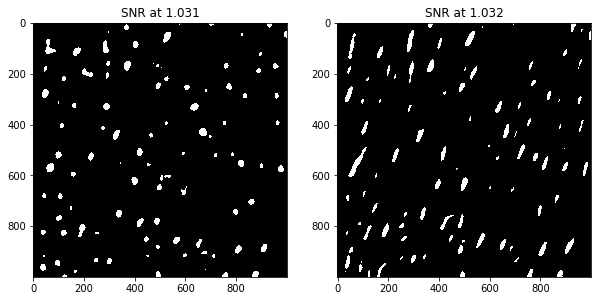

In [43]:
print ("this is the unhealthy region")
plot_response_image([unhealthy_response_SNR[0][1],unhealthy_response_SNR[1][1]],datatype='thresSNR',sameVmax=False)

In [44]:
def pasteImage(image, thresd_image, color):
    '''
    Set the R/G channel value to 255 to hightlight the
    hits from bad/good filter
    '''
    newimage = image.copy()
    if color == 'green':
        newimage[thresd_image==1,1] = 255
    elif color == 'red':
        newimage[thresd_image==1,0] = 255
    elif color == 'yellow':
        newimage[thresd_image==1,0:2] = 255
    return newimage

In [45]:
def generate_colored_images(oriImage,response):
    """
    Color 'green' where good filter has hits, 'red' where bad filter has hits.
    respone is a list containts the thresd SNR image
    """
    colored_images = []
    good_resp = response[0]
    bad_resp  = response[1]
    colored_images.append(pasteImage(oriImage,good_resp,'green'))
    colored_images.append(pasteImage(oriImage,bad_resp,'red'))
    
    return colored_images
                          
                          

In [46]:
# we want to color the detected cells in the original test image to get a better
# understanding

healthy_colored_images = generate_colored_images(test_image[0],[healthy_response_SNR[0][1],\
                                                                           healthy_response_SNR[1][1]])
    

In [47]:
unhealthy_colored_images = generate_colored_images(test_image[1],[unhealthy_response_SNR[0][1],\
                                                                           unhealthy_response_SNR[1][1]])

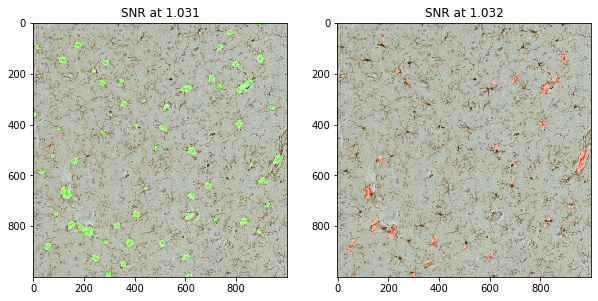

In [48]:
plot_response_image(healthy_colored_images,datatype='colored_response',sameVmax=False)


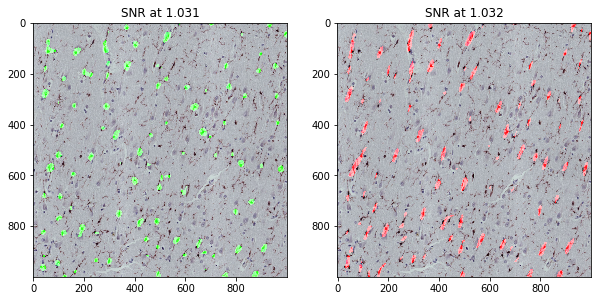

In [49]:
plot_response_image(unhealthy_colored_images,datatype='colored_response',sameVmax=False)


### Look at the above SNR response, in unhealthy test image, we have response of ram_filter and rod_filter overlapped, thus we try a sequential filtering process, namely, first apply the rod_filter then the ram_filter

In [50]:
#  now apply the filter sequentially; first the rod filter then the ramified filter
#
def sequentially_apply_filter(image,filters):
    '''
    image, the gray_scale tissue image
    filters, a list, contains the good and bad filter
    '''
    
    gfilter = filters[0] ; bfilter = filters[1]
    
    #since the bad filter signiture is larger than the good filter,
    # we apply the bad filter first
    bad_response = ndimage.convolve(image,bfilter)
    SNR_bad_response = mu.giveAnnulusSNR(bad_response,INNER_RADIUS,OUTER_RADIUS,\
                                         thresh=ROD_FILTER_SNR_THRES,verbose=False)
    
    bmask = SNR_bad_response[1].astype(np.uint8)
    
    #enlarge the mask a little bi
    kernal = np.ones((2,2),dtype=np.uint8)
    new_bmask = cv2.dilate(bmask,kernal)
    
    newimage = image.copy()
    newimage[new_bmask == 1] = 0
    
    
    good_response = ndimage.convolve(newimage,gfilter)
    SNR_good_response = mu.giveAnnulusSNR(good_response,INNER_RADIUS,OUTER_RADIUS,\
                                     thresh=RAM_FILTER_SNR_THRES,verbose=False)
    
    
    return SNR_good_response[1],SNR_bad_response[1]
    

In [51]:
gresp, bresp = sequentially_apply_filter(test_image_gray_scale[0],[ram_filter,rod_filter])

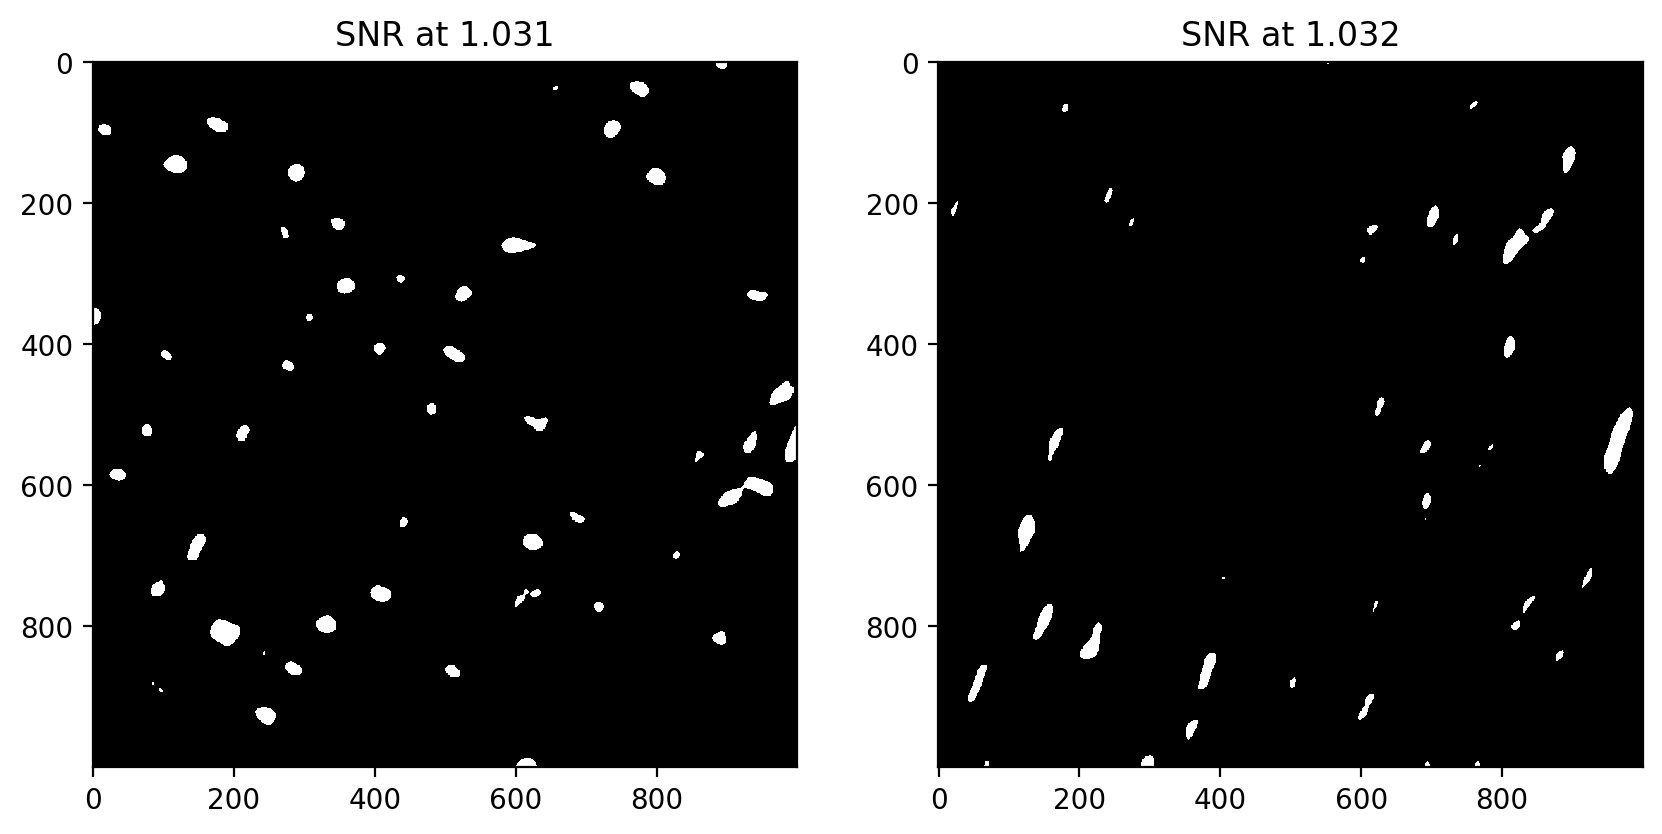

In [50]:
plot_response_image([gresp,bresp],datatype='thresSNR',sameVmax=False)

### we try the big scanned image

In [52]:
# try out the real big image
filepath=os.path.join(os.getcwd(),"TestImages/Big_Microglia.png")
big_image = cv2.imread(filepath)[2000:12000,2000:13000,:]



In [53]:
grayimage = normalize(invert_gray_scale(cv2.cvtColor(big_image,cv2.COLOR_RGB2GRAY)))


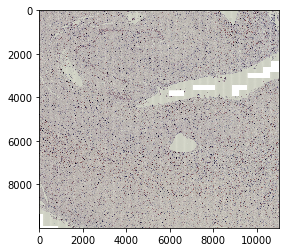

In [54]:
plt.imshow(big_image)

In [55]:
def divde_big_image(bigimage,grayscale=True):
    """
    divided the big grayscale image into 
    100 small images
    """
    dx = int(bigimage.shape[0]/10)
    dy = int(bigimage.shape[1]/10)
    
    if grayscale:
        small_images = [bigimage[dx*i:dx*(i+1),dy*j:dy*(j+1)]\
                for i in np.arange(10) for j in np.arange(10)]
    else:
        small_images = [bigimage[dx*i:dx*(i+1),dy*j:dy*(j+1),:]\
                for i in np.arange(10) for j in np.arange(10)]
    return small_images

In [58]:
def respone_on_small_images(small_images,filters):
    """
    get the response of ram and rod filters on the small images
    and calculate the ratio of ram filter
    """
    
    RAM_FILTER_SNR_THRES = 1.031
    ROD_FILTER_SNR_THRES = 1.032
    
    ram_filter = filters[0]
    rod_filter = filters[1]
    
    response = []
    ratio = []
    for i,j in enumerate(small_images):
        print ("now calculating small image %d" % (i+1))
        ram_resp,rod_resp = sequentially_apply_filter(j,[ram_filter,rod_filter])
        response.append((ram_resp,rod_resp))
        small_ratio = np.sum(ram_resp)/(np.sum(ram_resp) + np.sum(rod_resp))
        ratio.append(small_ratio)
        
    return response, ratio
        


In [ ]:

RAM_FILTER_SNR_THRES = 1.031
ROD_FILTER_SNR_THRES = 1.032
smallimages= divde_big_image(grayimage)
response,ratio = respone_on_small_images(smallimages,[ram_filter,rod_filter])

#this SNR value for 80y_2 "2018_07_28__1759_s3.png"
#RAM_FILTER_SNR_THRES = 1.031
#ROD_FILTER_SNR_THRES = 1.04
#smalliamges80y = divde_big_image(grayimage)

#response_80y,ratio_80y = respone_on_small_images(smalliamges80y,rod80_filter)


now calculating small image 1
now calculating small image 2
now calculating small image 3
now calculating small image 4
now calculating small image 5
now calculating small image 6
now calculating small image 7
now calculating small image 8
now calculating small image 9
now calculating small image 10
now calculating small image 11
now calculating small image 12
now calculating small image 13
now calculating small image 14
now calculating small image 15
now calculating small image 16
now calculating small image 17
now calculating small image 18
now calculating small image 19
now calculating small image 20
now calculating small image 21
now calculating small image 22
now calculating small image 23
now calculating small image 24
now calculating small image 25
now calculating small image 26
now calculating small image 27
now calculating small image 28
now calculating small image 29


/home/binsun/temp/mach_tutorial/mach/mach_util.py:200: RuntimeWarning: invalid value encountered in true_divide
  SNR = in_filt / out_filt
/home/binsun/temp/mach_tutorial/mach/mach_util.py:210: RuntimeWarning: invalid value encountered in greater
  threshed = np.greater(SNR,thresh)


now calculating small image 30
now calculating small image 31
now calculating small image 32


In [89]:
# Now we save the response and ratio into files,
# and use another ipython note book to analyze 
import pickle

with open('big_image_response','wb') as f:
    pickle.dump(response,f)
    
with open('big_image_ratio','wb') as f:
    pickle.dump(ratio,f)